# Supplemental Information Section B - Analysis of mutation frequency

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
import scipy as sp
import scipy.ndimage

# Our numerical workhorses
import numpy as np
import pandas as pd

# Import the project utils
import sys
sys.path.insert(0, '../')
import NB_sortseq_utils as utils

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.core.pylabtools import figsize

# Seaborn, useful for graphics
import seaborn as sns

sns.set_palette("deep", color_codes=True)
utils.set_plotting_style1()

%matplotlib inline

In [4]:
# load in library sequences 

mut_region_start = 0
mut_region_length = 70

data_fn = '../../data/sortseq_pymc_dump/20150513_marR_MG1655_LB_na_mut1_4bins_seq.csv'

In [5]:
#======================================================#
# load sequences and convert to matrix representation
#======================================================#

f = open(data_fn)
roi_list = [(line.split(',')[0][mut_region_start:mut_region_start+mut_region_length], line.split(',')[1].strip()) for line in f if line.strip()]
f.close()    

# number of sequences
N = len(roi_list)

# Convert each sequence into matrix representation
seq_mat = sp.zeros((4,mut_region_length,N),dtype=int)

for i, line in enumerate(roi_list):
    seq_mat[:,:,i] = utils.seq2mat(line[0])

In [6]:
#======================================================#
# We also need to know what the wild-type sequence was
# to calculate number of mutations. Lets load those in.
#======================================================#

data_fn_wt = 'input_data/seq_WT_marmut1.txt'

seq_mat_wt = sp.zeros((4,mut_region_length,1),dtype=int)
seq_mat_wt_inv = sp.zeros((4,mut_region_length,1),dtype=int)

f = open(data_fn_wt)
for i, line in enumerate(f):
    if line.strip():
        sb = line.split(',')
        seq_mat_wt[:,:,i] = utils.seq2mat(sb[0][0:mut_region_length])
f.close()

# To determine whether a matrix has a mutation, I will
# multiply (inner product) it by an inverted wild-type 
# sequence (positions associated with wild-type sequence 
# have value 0, and 1 otherwise). The sum of this matrix
# product will give the number of mutations.
# Let's generate this inverted wild-type matrix.
for i in range(0,mut_region_length):
    for j in range(0,4):
        if seq_mat_wt[j,i] ==1:
            seq_mat_wt_inv[j,i] = 0
        else:
            seq_mat_wt_inv[j,i] = 1

In [7]:
#======================================================#
# calculate 'mutation' matrices
#======================================================#

seq_mat_mut = np.zeros((4,mut_region_length,N),dtype=int)
for i in range(0,N):
    seq_mat_mut[:,:,i] = seq_mat[:,:,i] * seq_mat_wt_inv[:,:,0]

In [8]:
#======================================================#
# Calculate number of sequences that have 1-30
# mutations in their sequence.
# This will take a while. I bet there is a better way
# to calculate this.
#======================================================#
N_mut = np.zeros(25,dtype=int)

for i in range(0,25):
    seq_mat_mut_temp = seq_mat_mut.copy()
    
    # A matrix will sum to 4 if it has 4 mutations.
    # Use this to check number of sequences with i mutations
    if i == 0:
        count = 0
        for j in range(0,N):
            if seq_mat_mut_temp[:,:,j].sum() !=i:
                seq_mat_mut_temp[:,:,j] = seq_mat_mut_temp[:,:,j]*0.0
            else:
                count += 1
        N_mut[i] = count
        continue
    for j in range(0,N):
        if seq_mat_mut_temp[:,:,j].sum() !=i:
            seq_mat_mut_temp[:,:,j] = seq_mat_mut_temp[:,:,j]*0.0
    # divide by number of mutations (sum of each good matrix)
    N_mut[i] = seq_mat_mut_temp.sum()/i
    print('Considering sequences with ',i, ' mutations.')


Considering sequences with  1  mutations.
Considering sequences with  2  mutations.
Considering sequences with  3  mutations.
Considering sequences with  4  mutations.
Considering sequences with  5  mutations.
Considering sequences with  6  mutations.
Considering sequences with  7  mutations.
Considering sequences with  8  mutations.
Considering sequences with  9  mutations.
Considering sequences with  10  mutations.
Considering sequences with  11  mutations.
Considering sequences with  12  mutations.
Considering sequences with  13  mutations.
Considering sequences with  14  mutations.
Considering sequences with  15  mutations.
Considering sequences with  16  mutations.
Considering sequences with  17  mutations.
Considering sequences with  18  mutations.
Considering sequences with  19  mutations.
Considering sequences with  20  mutations.
Considering sequences with  21  mutations.
Considering sequences with  22  mutations.
Considering sequences with  23  mutations.
Considering sequence

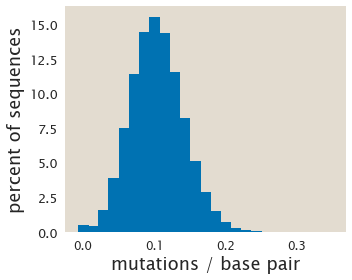

In [9]:
#======================================================#
# plot the result
#======================================================#
ind = np.arange(0,25)
ind = np.arange(25)/70
fig = plt.figure(1, figsize(5, 4))
ax = plt.subplot(111)            
plt.bar(ind,100*(N_mut/N), width=0.015)
# ax.set_xlim(0,0.35)
ax.set_ylabel('percent of sequences')
ax.set_xlabel('mutations / base pair')
ax.grid(b=False)

plt.tight_layout()

figname_out = 'output_figs/figS1_mutation_histogram.pdf'
fig.savefig(figname_out, format='pdf')